# Testing the source of outshining
The sister notebook to this tested out effects on outshining when changing 3 things for the input spectrum:
<ol>
1. Observational noise purturbing the data (assumed Gaussian independent noise when constructing this, SNR15) <br>
2. dust<br>
3. Uniform and homogeneous metallicity or patchy and evolving metallicity<br>
</ol>
which results in 8 runs for all combinations of on and off. In that, it is found the first factor is the main culprit in worsening outshining. Decker French's 2020 paper assumes fixed t_form and tau parameters for the older population to perhaps work around this issue. Let's try that here... <br>
t_form parameter (time when the older population started forming) is fixed as the best fit t_form parameter when the psb2 functional form is fitted to the true SFH using scipy.curve_fit. Value is 12.6818189 Gyr in lookback time

# Section A. Reading fit posteriors and make SFH plots

In [1]:
import numpy as np 
import bagpipes as pipes

from PyAstronomy import pyasl
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,peak_prominences

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


Load in the true SFH from Yirui's simulation. This SFH applies to all 8 fits.

In [2]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

Relevent functions for bagpipes spectrum reading...

In [3]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((int(nbins), spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec

def mask_sky(wave):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    masksize=10
    lines_vac = np.array([5578.5486,4279.2039,6301.7423,6365.7595])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask

def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24,6564.61,6549.8490,6585.2784, 6717., 6731., 5893., 6302.046, 6918.6, 3870.])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        if lines[i] > 6500 and lines[i] < 6600 or lines[i]==5893:
            masksize = 10
        else:
            masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    #ind = np.where(wave<3000)
    #mask.extend(ind[0])    

    return mask

def load_manga_spec_mask(ID, full=True):
    """ Extracts correct spectrum and masks emission lines """
    """ Note redshift, flux etc. are all passed silently!!!!"""
   
    spectrum = np.loadtxt(fname=run_params['spectrum_dir']+
                          "/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
  
    # pixel mask from DAP, not clear if we want to use this or not. Try fort
    #pixmask = (np.where(mask[pix_x,pix_y,:] !=0))[0]
    #spectrum[pixmask, 2] = 9.9*10**99.


    # nebular emission lines and interstellar absorption lines
    linemask = mask_em(spectrum[:,0]/(1+z))
    spectrum[linemask, 2] = 9.9*10**99.
    
    # skylines
    linemask = mask_sky(spectrum[:,0])
    spectrum[linemask, 2] = 9.9*10**99.
  
    for j in range(len(spectrum)):
        if (spectrum[j, 1] == 0) or (spectrum[j, 2] <= 0):
            spectrum[j, 2] = 9.9*10**99.
    
    if full == False:
        endmask = (spectrum[:,0]/(1+z) < 7500) # just miles range
    else:
        endmask = (spectrum[:,0]>0)
    if run_params['bin_by'] == 1:
        return spectrum[endmask]
    else:
        return bin(spectrum[endmask], run_params['bin_by'])

Functions to easily load and plot the posteriors in fancy plots

In [14]:
def process_params(run_params):
    galID = run_params['galID_parts'][0]
    runID = run_params['runID_parts'][0]
    spectrum_dir = run_params['spectrum_dir_root']

    if run_params['PSF']:
        spectrum_dir += 'with_PSF/'
        galID += '_with_PSF'
    else:
        spectrum_dir += 'no_PSF/'
        galID += '_no_PSF'

    if run_params['dust']:
        spectrum_dir += 'with_dust'
        galID += '_with_dust'
        runID += '_with_dust'
    else:
        spectrum_dir += 'no_dust'
        galID += '_no_dust'
        runID += '_no_dust'

    if run_params['noise']:
        galID += '_with_noise'
        runID += '_with_noise'
    else:
        runID += '_no_noise'

    runID += f"_bin_by_{run_params['bin_by']}_{run_params['Rspec']}_Rspec"

    galID += run_params['galID_parts'][1]
    runID += run_params['runID_parts'][1]
    run_params['spectrum_dir'] = spectrum_dir
    run_params['galID'] = galID
    run_params['runID'] = runID
    
    return run_params

def plot_spec2(fit, ID, runID):
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()
    
# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

def dpl(t, t_burst, strength, alpha=450, beta=250):
    return strength/((t/t_burst)**alpha + (t/t_burst)**-beta)

def cal_f_burst(ages, sfh, print_=True):
    #1. find_peaks (ignoring age) with prominance > 1/10 * max SFR within last 2Gyr
    age_of_universe = max(ages)
    last_2gyr_ages = ages[ages>age_of_universe-2]
    last_2gyr_sfh = sfh[ages>age_of_universe-2]
    peak_ind, _ = find_peaks(last_2gyr_sfh, prominence=0.1*max(sfh))
    
    #2. find the peak with the largest prominance
    if len(peak_ind)>1:
        if print_==True:
            print('more than one peak')
        prominences = peak_prominences(last_2gyr_sfh, peak_ind)[0]
        t_peak = last_2gyr_ages[peak_ind[prominences==max(prominences)][0]]
    else:
        t_peak = last_2gyr_ages[peak_ind[0]]
    
    #3. find the beginning of the peak using when gradient changes sign to set as begin burst age
    grad = np.gradient(sfh, ages)
    for grad_i in grad[ages<t_peak]:
        if grad_i<0:
            t_begin = ages[grad==grad_i][0]
            break
    if print_==True:
        print('begin burst age = ', t_begin)
    burst_sfh = sfh[ages>=t_begin]
    burst_ages = ages[ages>=t_begin]
    
    #4. calculate f_burst
    m_burst = np.trapz(y=burst_sfh[::-1], x=burst_ages[::-1])
    m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
    f_burst = m_burst/m_total
    
    #5. fit for the isolated burst SFH for t_burst
    try: 
        popt, pcov = curve_fit(dpl, burst_ages, burst_sfh, p0=[t_peak,1,450,250])
        t_burst = popt[0]
        if np.isinf(np.sum(pcov)) or t_burst<t_begin:
            raise RuntimeError()
        if print_==True:
            print('t_burst fitted with dpl')
    except RuntimeError:
        t_burst = burst_ages[np.argmax(burst_sfh)]
        if print_==True:
            print('t_burst dpl fitting failed, using maximum SFH of burst as t_burst')
    return f_burst, t_burst

def fit_f_burst(ages, sfh, age_at_z):
    # using scipy curve fit to get a fit to the true SFH
    popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                          bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
    [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
    tform = age_at_z - age
    tburst = age_at_z - burstage
    return fburst, tburst, tform, alpha, beta

def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh
    
def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = fit_f_burst(
        model_lookbacktime.copy(), model_sfh, age_at_z)
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb2:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb2:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax
    
def make_plots(galaxy, ID, runID, model_ages, predict_sfh):
    fit = pipes.fit(galaxy, {}, run=runID)
    plot_spec2(fit, ID, runID)
    fig = fit.plot_sfh_posterior(save=True, show=True)
    fig = fit.plot_corner(save=True, show=True)
    plot_sfh(fit, model_ages, predict_sfh, ID, runID)

## 1. uniform Z without dust and no noise (fitting has dust turned off, fixed solar metallicity)

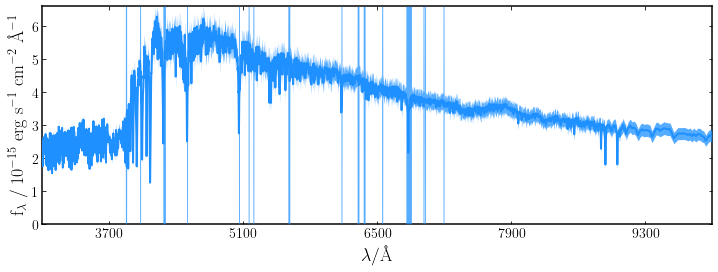

In [15]:
# define run params, first is no dust no noise purturbation, uniform Z
run_params_uZ_ndust_nnoise={}
run_params_uZ_ndust_nnoise['PSF'] = True
run_params_uZ_ndust_nnoise['dust'] = False
run_params_uZ_ndust_nnoise['noise'] = False
run_params_uZ_ndust_nnoise['spectrum_dir_root'] = '../Yirui_test_cube/snap119_uniformZ/'
run_params_uZ_ndust_nnoise['galID_parts'] = ['2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ','_SNR15']
run_params_uZ_ndust_nnoise['runID_parts'] = ['uniformZ', '_fixed_tform']
run_params_uZ_ndust_nnoise['Rspec'] = 4340
run_params_uZ_ndust_nnoise['bin_by'] = 1
z = 0.04
run_params_uZ_ndust_nnoise = process_params(run_params_uZ_ndust_nnoise)
run_params = run_params_uZ_ndust_nnoise.copy()

galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)
fig = galaxy.plot()


Results loaded from pipes/posterior/uniformZ_no_dust_no_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_SNR15.h5



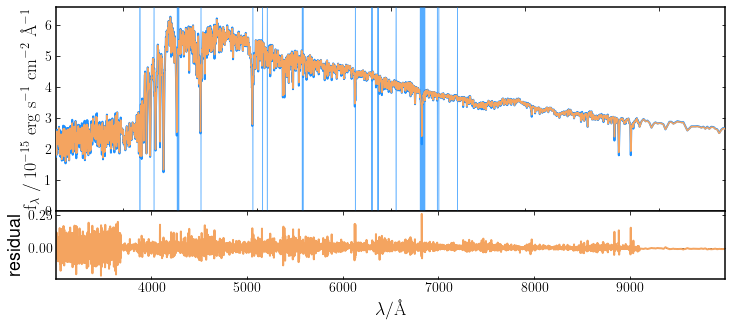

only recovered 0.6004898128185227 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374072704108647
posterior f_burst and t_burst: [0.15270523 0.16133985 0.17033589] [12.33561664 12.36194788 12.41463219]


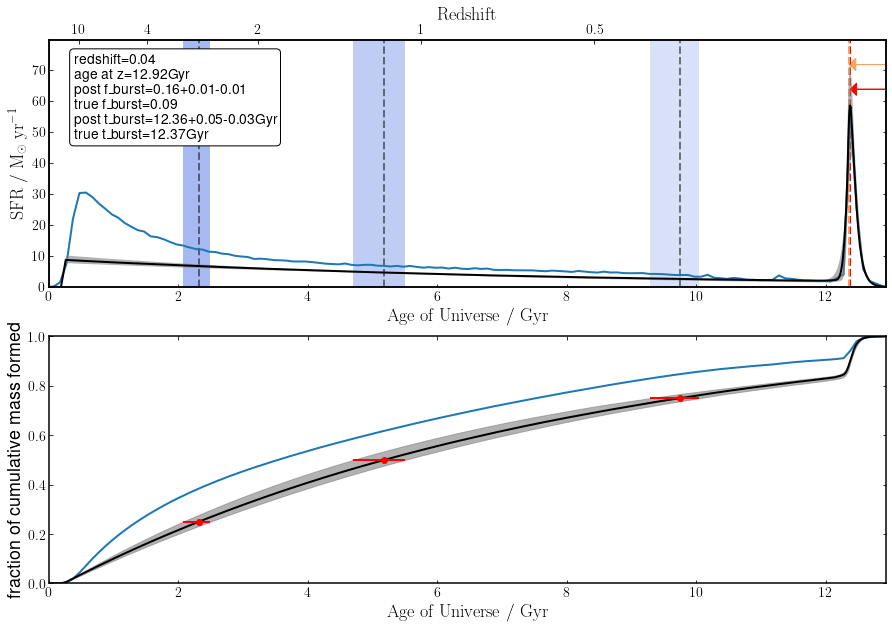

In [16]:
# fitting results
make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

## 2. uniform Z without dust and with noise (fitting has dust turned off, fixed solar metallicity)


Results loaded from pipes/posterior/uniformZ_no_dust_with_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_with_noise_SNR15.h5



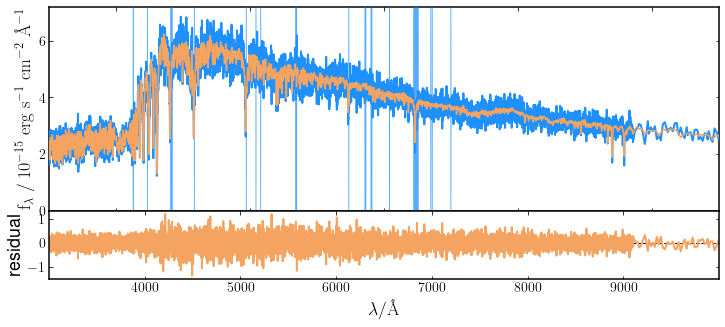

only recovered 0.5924855618995001 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374076167741402
posterior f_burst and t_burst: [0.15686525 0.16589956 0.17686343] [12.3278414  12.35566208 12.41836513]


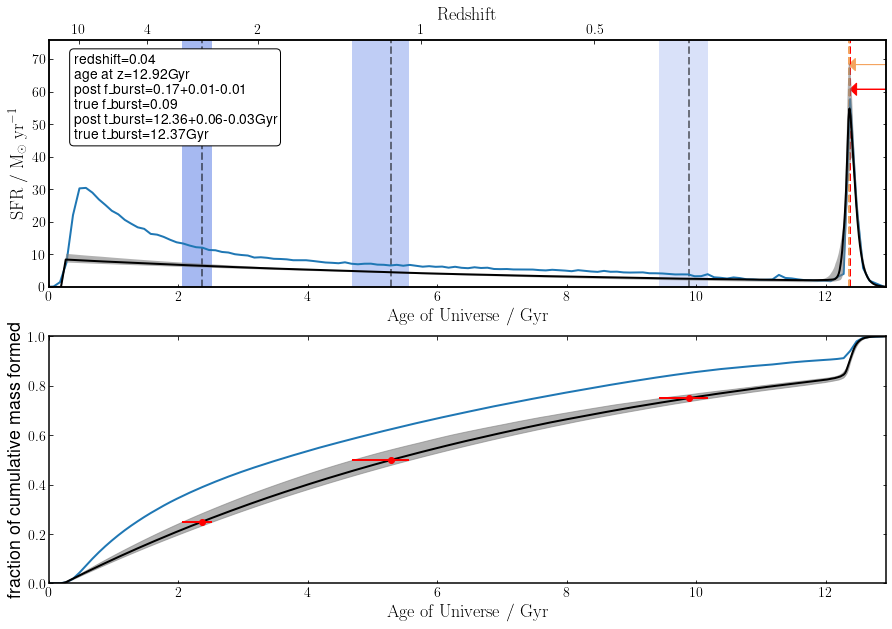

In [17]:
# now no dust with noise purturbation
run_params_uZ_ndust_ynoise = run_params_uZ_ndust_nnoise.copy()
run_params_uZ_ndust_ynoise['dust'] = False
run_params_uZ_ndust_ynoise['noise'] = True
run_params_uZ_ndust_ynoise = process_params(run_params_uZ_ndust_ynoise)
run_params = run_params_uZ_ndust_ynoise.copy()
galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

## 3. uniform Z with dust and no noise (fitting has fixed solar metallicity)


Results loaded from pipes/posterior/uniformZ_with_dust_no_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_with_dust_SNR15.h5



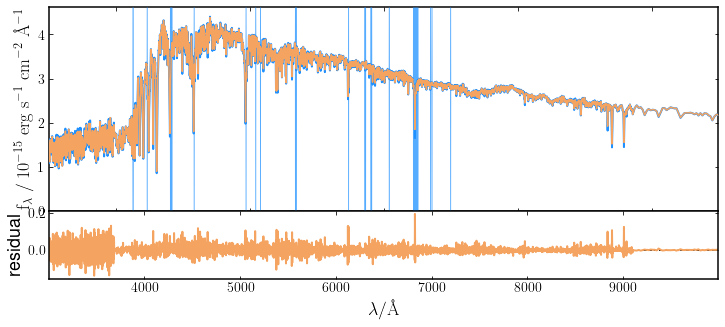

only recovered 0.9965314826274133 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.37406837667364
posterior f_burst and t_burst: [0.14347292 0.15790094 0.1745099 ] [12.38051138 12.46926562 12.53338657]


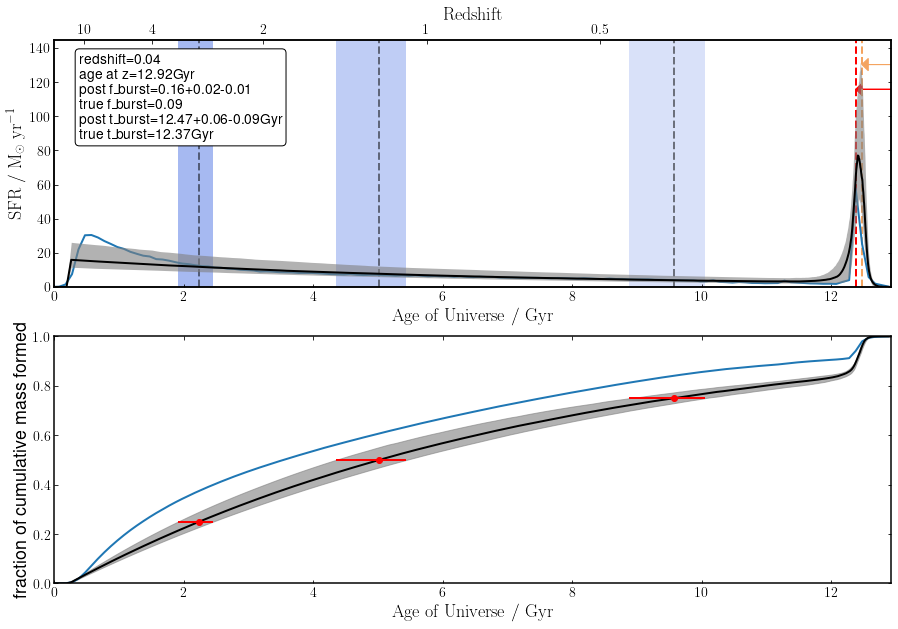

In [18]:
# now with dust no noise purturbation
run_params_uZ_ydust_nnoise = run_params_uZ_ndust_nnoise.copy()
run_params_uZ_ydust_nnoise['dust'] = True
run_params_uZ_ydust_nnoise['noise'] = False
run_params_uZ_ydust_nnoise = process_params(run_params_uZ_ydust_nnoise)
run_params = run_params_uZ_ydust_nnoise.copy()
galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

## 4. uniform Z with dust and with noise (fitting has fixed solar metallicity)


Results loaded from pipes/posterior/uniformZ_with_dust_with_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_with_dust_with_noise_SNR15.h5



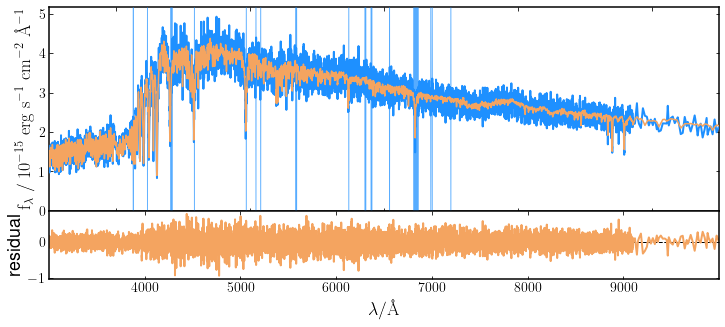

only recovered 0.8455648086170146 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374117462478662
posterior f_burst and t_burst: [0.18168066 0.20733025 0.23482653] [12.53233201 12.5652102  12.58888942]


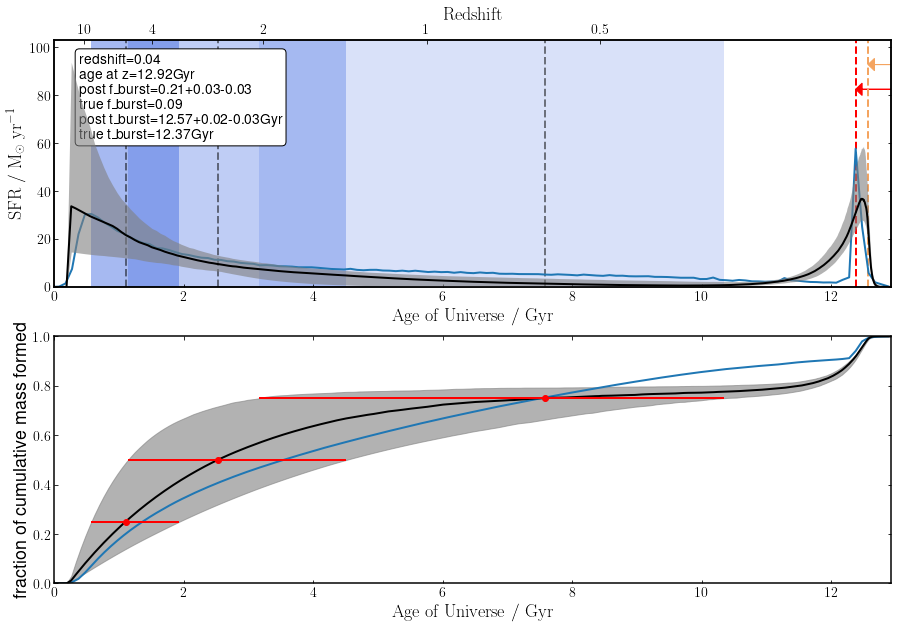

In [19]:
# now with dust with noise purturbation
run_params_uZ_ydust_ynoise = run_params_uZ_ndust_nnoise.copy()
run_params_uZ_ydust_ynoise['dust'] = True
run_params_uZ_ydust_ynoise['noise'] = True
run_params_uZ_ydust_ynoise = process_params(run_params_uZ_ydust_ynoise)
run_params = run_params_uZ_ydust_ynoise.copy()
galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

## Simulation-matched metallicity
## 5. varying Z without dust and no noise (fitting has dust turned off)


Results loaded from pipes/posterior/simulatedZ_no_dust_no_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test.h5



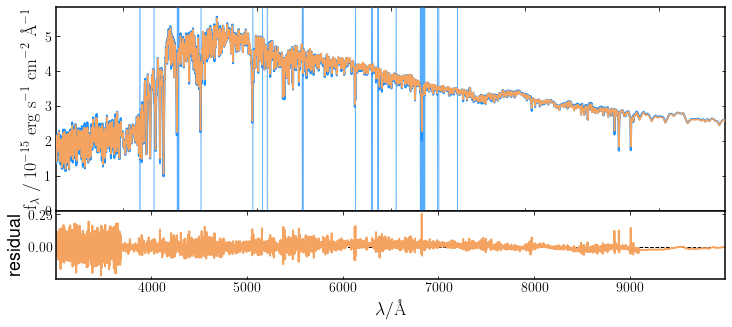

only recovered 0.5470794132169023 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374079209430379
posterior f_burst and t_burst: [0.22219863 0.2362183  0.2584827 ] [12.37416003 12.4286638  12.48616368]


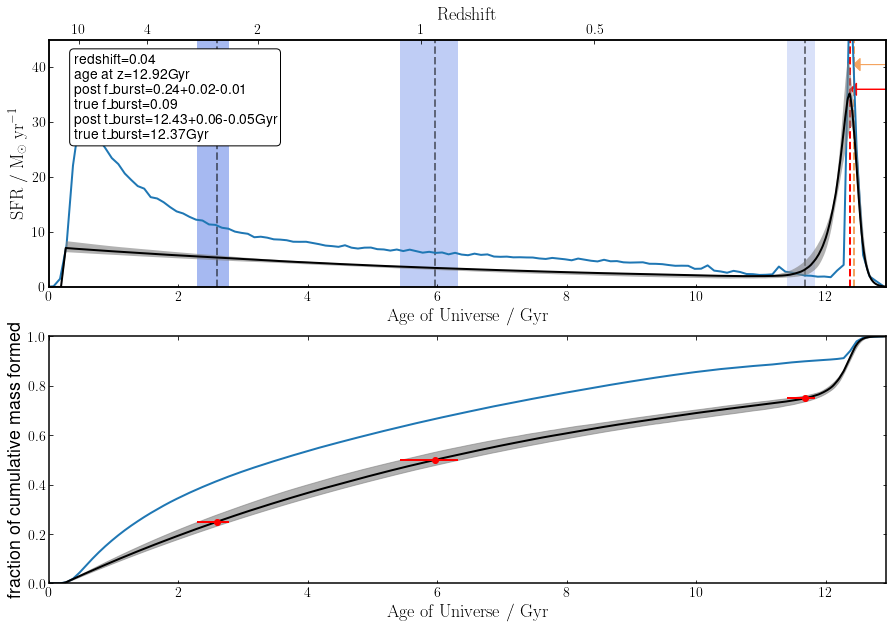

In [23]:
# and now back to simulation-matched metallicity elements. This introduces model-data descrapancies that can never
# be perfectly modelled by bagpipes
# no dust no noise
run_params_sZ_ndust_nnoise = {}
run_params_sZ_ndust_nnoise['PSF'] = True
run_params_sZ_ndust_nnoise['dust'] = False
run_params_sZ_ndust_nnoise['noise'] = False
run_params_sZ_ndust_nnoise['spectrum_dir_root'] = '../Yirui_test_cube/snap119/'
run_params_sZ_ndust_nnoise['galID_parts'] = ['2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP','_SNR15_outshining_test']
run_params_sZ_ndust_nnoise['runID_parts'] = ['simulatedZ', '_fixed_tform']
run_params_sZ_ndust_nnoise['Rspec'] = 4340
run_params_sZ_ndust_nnoise['bin_by'] = 1
run_params_sZ_ndust_nnoise = process_params(run_params_sZ_ndust_nnoise)
run_params = run_params_sZ_ndust_nnoise.copy()

galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)


## 6. varying Z without dust and with noise (fitting has dust turned off)


Results loaded from pipes/posterior/simulatedZ_no_dust_with_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_with_noise_SNR15_outshining_test.h5



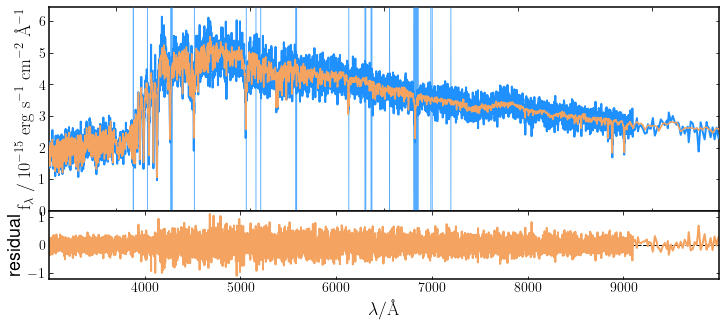

only recovered 0.539793453733423 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374081251822973
posterior f_burst and t_burst: [0.21932615 0.24614102 0.30053411] [12.35963431 12.46785015 12.5532706 ]


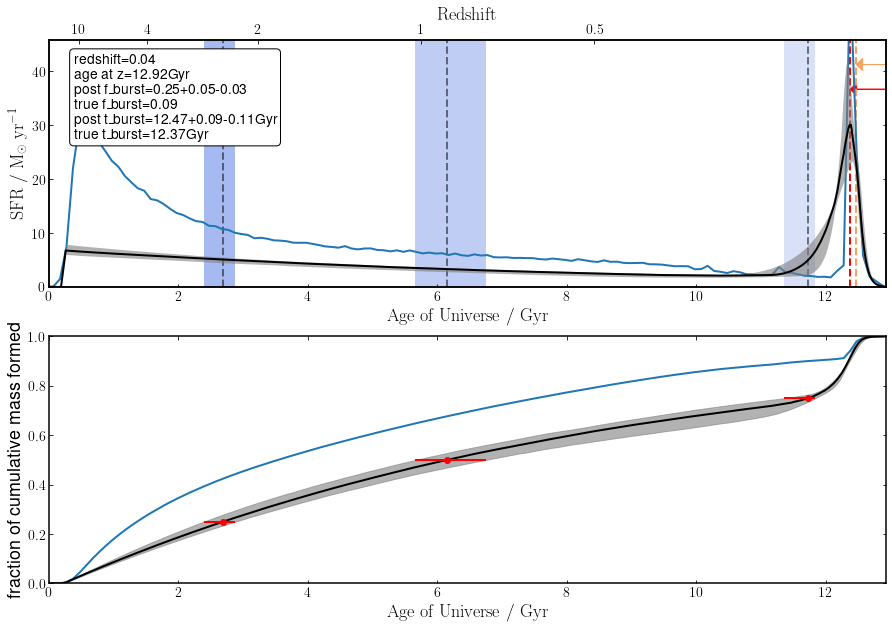

In [24]:
# now no dust with noise purturbation
run_params_sZ_ndust_ynoise = run_params_sZ_ndust_nnoise.copy()
run_params_sZ_ndust_ynoise['dust'] = False
run_params_sZ_ndust_ynoise['noise'] = True
run_params_sZ_ndust_ynoise = process_params(run_params_sZ_ndust_ynoise)
run_params = run_params_sZ_ndust_ynoise.copy()
galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

## 7. varying Z with dust and no noise


Results loaded from pipes/posterior/simulatedZ_with_dust_no_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_SNR15_outshining_test.h5



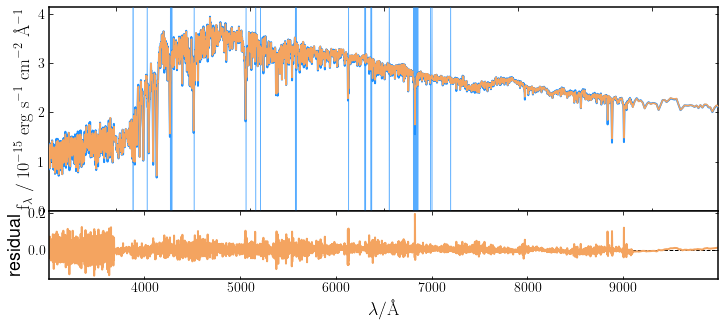

only recovered 1.5188652690496258 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374074353156908
posterior f_burst and t_burst: [0.17839605 0.20197196 0.23437955] [12.36082161 12.49804834 12.54834647]


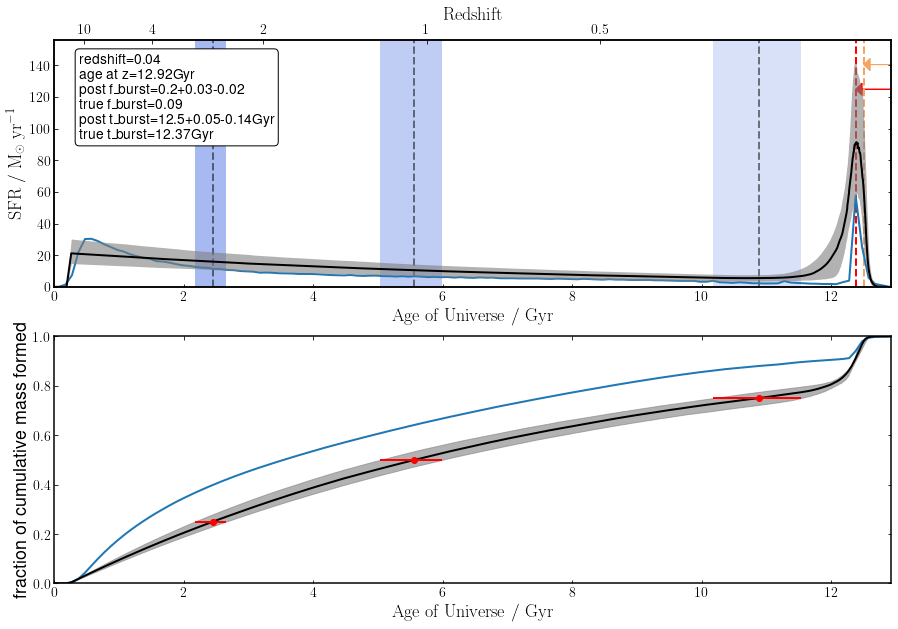

In [25]:
# now with dust no noise purturbation
run_params_sZ_ydust_nnoise = run_params_sZ_ndust_nnoise.copy()
run_params_sZ_ydust_nnoise['dust'] = True
run_params_sZ_ydust_nnoise['noise'] = False
run_params_sZ_ydust_nnoise = process_params(run_params_sZ_ydust_nnoise)
run_params = run_params_sZ_ydust_nnoise.copy()
galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

## 8. varying Z with dust and with noise 


Results loaded from pipes/posterior/simulatedZ_with_dust_with_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_with_noise_SNR15_outshining_test.h5



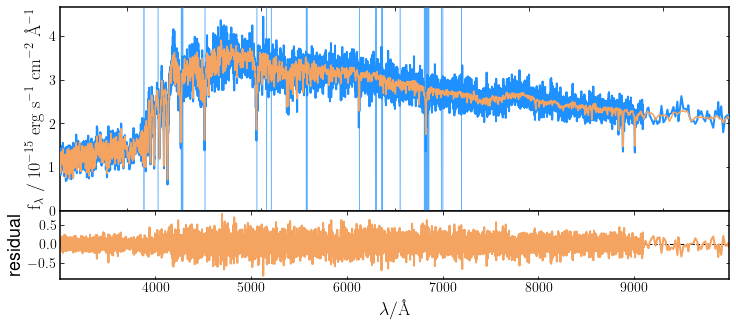

only recovered 1.5407629222899544 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374102655129171
posterior f_burst and t_burst: [0.22344403 0.26595489 0.32775531] [12.49805169 12.55916053 12.59209107]


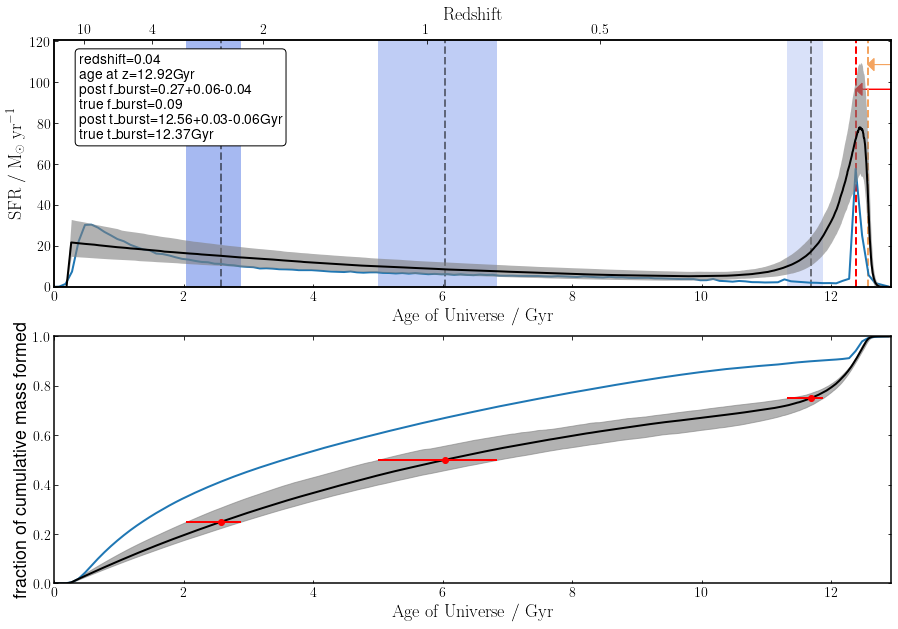

In [26]:
# now with dust with noise purturbation
run_params_sZ_ydust_ynoise = run_params_sZ_ndust_nnoise.copy()
run_params_sZ_ydust_ynoise['dust'] = True
run_params_sZ_ydust_ynoise['noise'] = True
run_params_sZ_ydust_ynoise = process_params(run_params_sZ_ydust_ynoise)
run_params = run_params_sZ_ydust_ynoise.copy()
galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)

make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

# Section B. Comparing things with violin plots
All the code to compute the posterior distributions

In [31]:
class bagpipes_result:
    def __init__(self, run_params, Z, sim_data_path):
        self.truth_dict = {}
        self.run_params = run_params
        self.Z = Z
        ID = run_params['galID']
        runID = run_params['runID']
        galaxy = pipes.galaxy(ID, load_manga_spec_mask, photometry_exists=False)
        self.fit = pipes.fit(galaxy, {}, run=runID)
        
        #redshift treatments
        self.sim_data = np.loadtxt(sim_data_path)
        if 'redshift' in self.fit.posterior.samples.keys():
            post_z = np.median(self.fit.posterior.samples['redshift'])
        else: post_z = 0.04
        self.age_at_z = cosmo.age(post_z).value

        #model sfh
        self.model_sfh = self.sim_data[:,2]
        self.model_lb_time = self.sim_data[:,0]
        self.model_ages = self.age_at_z - self.model_lb_time
        
        #posterior sfh
        self.post_sfh = self.fit.posterior.samples['sfh']
        self.age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
        self.post_ages = self.age_of_universe - self.fit.posterior.sfh.ages*10**-9
    
    def Mstar(self):
        model_Mstar = np.log10(np.trapz(y=self.model_sfh, x=self.model_lb_time)*10**9)
        self.truth_dict['Mstar'] = model_Mstar

        Mstar_key = 'psb2:massformed'
        self.post_Mstar_ = self.fit.posterior.samples[Mstar_key]
        post_Mstar = np.percentile(self.post_Mstar_, (16,50,84))

        print('model Mstar =', model_Mstar)
        print('posterior Mstar =', post_Mstar)

    def cal_f_burst(self, ages, sfh, print_=True):
        #1. find_peaks (ignoring age) with prominance > 1/10 * max SFR within last 2Gyr
        age_of_universe = max(ages)
        last_2gyr_ages = ages[ages>age_of_universe-2]
        last_2gyr_sfh = sfh[ages>age_of_universe-2]
        peak_ind, _ = find_peaks(last_2gyr_sfh, prominence=0.1*max(sfh))

        #2. find the peak with the largest prominance
        if len(peak_ind)>1:
            if print_==True:
                print('more than one peak')
            prominences = peak_prominences(last_2gyr_sfh, peak_ind)[0]
            t_peak = last_2gyr_ages[peak_ind[prominences==max(prominences)][0]]
        else:
            t_peak = last_2gyr_ages[peak_ind[0]]

        #3. find the beginning of the peak using when gradient changes sign to set as begin burst age
        grad = np.gradient(sfh, ages)
        for grad_i in grad[ages<t_peak]:
            if grad_i<0:
                t_begin = ages[grad==grad_i][0]
                break
        if print_==True:
            print('begin burst age = ', t_begin)
        burst_sfh = sfh[ages>=t_begin]
        burst_ages = ages[ages>=t_begin]

        #4. calculate f_burst
        m_burst = np.trapz(y=burst_sfh[::-1], x=burst_ages[::-1])
        m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
        f_burst = m_burst/m_total

        #5. fit for the isolated burst SFH for t_burst
        try: 
            popt, pcov = curve_fit(dpl, burst_ages, burst_sfh, p0=[t_peak,1,450,250])
            t_burst = popt[0]
            if np.isinf(np.sum(pcov)) or t_burst<t_begin:
                raise RuntimeError()
            if print_==True:
                print('t_burst fitted with dpl')
        except RuntimeError:
            t_burst = burst_ages[np.argmax(burst_sfh)]
            if print_==True:
                print('t_burst dpl fitting failed, using maximum SFH of burst as t_burst')
        return f_burst, t_burst
    
    def fit_f_burst(self, ages, sfh):
        # using scipy curve fit to get a fit to the true SFH
        popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                              bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
        [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
        tform = self.age_at_z - age
        tburst = self.age_at_z - burstage
        return fburst, tburst, tform, alpha, beta
    
    def f_t_burst(self):
        #calculate model burst fraction
        model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = self.fit_f_burst(
            self.model_lb_time, self.model_sfh)
        self.truth_dict['fburst'] = model_f_burst
        self.truth_dict['tburst'] = model_t_burst
        #self.truth_dict['tform'] = model_t_form
        self.truth_dict['alpha'] = model_alpha
        self.truth_dict['beta'] = model_beta
        self.truth_dict['Mold'] = np.log10(10**self.truth_dict['Mstar']*(1-model_f_burst))
        self.truth_dict['Mnew'] = np.log10(10**self.truth_dict['Mstar']*model_f_burst)
        print('model f_burst and t_burst:',model_f_burst,model_t_burst)

        #calculate posterior burst fraction
        if 'iyer2019:tx' in self.fit.posterior.samples.keys():
            self.post_f_burst_ = np.zeros(len(self.post_sfh))
            self.post_t_burst_ = np.zeros(len(self.post_sfh))
            for i,sfh in enumerate(self.post_sfh):
                f_burst_i,t_burst_i, = self.fit_f_burst(self.fit.posterior.sfh.ages, sfh)
                self.post_f_burst_[i] = f_burst_i
                self.post_t_burst_[i] = t_burst_i
            post_f_burst = np.percentile(self.post_f_burst_, (16,50,84))
            post_t_burst = np.percentile(self.post_t_burst_, (16,50,84))

        else:
            #use psb2's built in fburst and tburst posteriors
            self.post_f_burst_ = self.fit.posterior.samples['psb2:fburst']
            self.post_t_burst_ = self.age_of_universe-self.fit.posterior.samples['psb2:burstage']
            #self.post_t_form_ = self.age_of_universe-self.fit.posterior.samples['psb2:age']
            self.post_alpha_ = self.fit.posterior.samples['psb2:alpha']
            self.post_beta_ = self.fit.posterior.samples['psb2:beta']
            self.post_Mold_ = np.log10(10**self.post_Mstar_*(1-self.post_f_burst_))
            self.post_Mnew_ = np.log10(10**self.post_Mstar_*self.post_f_burst_)
            post_f_burst = np.percentile(self.post_f_burst_, (16,50,84))
            post_t_burst = np.percentile(self.post_t_burst_, (84,50,16))

        print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
        
    def cal_f_gyr(self, ages, sfh, duration):
        # calculating the fractional mass formed in the most recent x Gyr defined in "duration"
        age_of_universe = max(ages)
        m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
        recent_sfh = sfh[ages>=(age_of_universe-duration)]
        recent_ages = ages[ages>=(age_of_universe-duration)]
        m_recent = np.trapz(y=recent_sfh[::-1], x=recent_ages[::-1])
        return m_recent/m_total
    
    def f_gyr(self):
        #model
        model_f10 = self.cal_f_gyr(self.model_ages, self.model_sfh, 1.0)
        model_f15 = self.cal_f_gyr(self.model_ages, self.model_sfh, 1.5)
        self.truth_dict['f10'] = model_f10
        self.truth_dict['f15'] = model_f15
        print('model fractions = ',model_f10,model_f15)

        #posterior
        self.post_f10_ = np.zeros(len(self.post_sfh))
        self.post_f15_ = np.zeros(len(self.post_sfh))
        for i,sfh in enumerate(self.post_sfh):
            self.post_f10_[i] = self.cal_f_gyr(self.post_ages, sfh, 1)
            self.post_f15_[i] = self.cal_f_gyr(self.post_ages, sfh, 1.5)
        post_f10 = np.percentile(self.post_f10_, (16,50,84))
        post_f15 = np.percentile(self.post_f15_, (16,50,84))
        print('posterior fractions = ',post_f10,post_f15)
    
    def cal_tquench(self, lb_time, sfh, plot=False):
        logage_lhs = pipes.utils.make_bins(np.log10(lb_time), make_rhs=True)[0]
        age_lhs = 10**(logage_lhs)
        age_lhs[0] = 0.
        hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
        age_lhs[-1] = 10**9*hubble_time
        age_widths = age_lhs[1:] - age_lhs[:-1]
        tH = (cosmo.age(0.04).value-lb_time)*10**9

        ind_2gyr = (np.where(lb_time < 2))[0]

        ssfr = sfh/np.flip(np.cumsum(np.flip(sfh*age_widths*10**9,0)),0)
        if len(np.where(ssfr>0.2/tH)[0]) !=0:
            t1 = tH[(np.where(ssfr>0.2/tH))[0][0]]
        if len(np.where(ssfr>1/tH)[0]) !=0:
            t2 = tH[(np.where(ssfr>1/tH))[0][0]]
        t3 = tH[(np.where(ssfr == np.max(ssfr[ind_2gyr])))[0][0]]

        if t1>0 and t2>0:
            tquench_from_1 = (t1-t2)*10**-9
        if t1>0:
            tquench_from_peak = (t1-t3)*10**-9
        if t2<t3:
            tquench_from_1 = tquench_from_peak = np.nan

        if plot==True:
            fig,ax = plt.subplots(figsize=[15,6])
            ax.plot(tH*10**-9,np.log10(ssfr),marker='^')
            ax.plot(tH*10**-9,np.log10(1/tH))
            ax.plot(tH*10**-9,np.log10(0.2/tH))
            ax.vlines(np.array([t1,t2,t3])*10**-9, *ax.get_ylim(), color='k', ls='--')
            ax.set_xlim(cosmo.age(0.04).value, 0.)
            ax.set_xlabel('Age of Universe / Gyr')
            ax.set_ylabel('sSFR')
            plt.show()

        return tquench_from_1,tquench_from_peak
    
    def tquench(self, plot=True):
        result = self.cal_tquench(self.model_lb_time,self.model_sfh,plot=False)
        self.truth_dict['tquenchfrom1'] = result[0]
        self.truth_dict['tquenchfrompeak'] = result[1]
        print('model tquench from 1 and from peak =',result)
        
        #--- age bins ---
        sfh_ages = self.fit.posterior.sfh.ages*10**-9
        logage_lhs = pipes.utils.make_bins(np.log10(sfh_ages), make_rhs=True)[0]
        age_lhs = 10**(logage_lhs)
        age_lhs[0] = 0.
        hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
        age_lhs[-1] = 10**9*hubble_time
        age_widths = age_lhs[1:] - age_lhs[:-1]

        ind_2gyr = (np.where(self.fit.posterior.sfh.ages < 2*10**9))[0]

        nsamp = self.fit.posterior.samples["sfh"].shape[0]
        ssfr = np.zeros((nsamp,len(sfh_ages)))
        t1 = np.zeros(nsamp)
        t2 = np.zeros(nsamp)
        t3 = np.zeros(nsamp)
        tH = (self.fit.posterior.sfh.age_of_universe-self.fit.posterior.sfh.ages)


        for k in range(nsamp):
            ssfr[k,:] = self.fit.posterior.samples["sfh"][k,:]/np.flip(np.cumsum(np.flip(self.fit.posterior.samples["sfh"][k,:]*age_widths*10**9,0)),0)
            if len(np.where(ssfr[k,:]>0.2/tH)[0]) !=0:
                t1[k] = tH[(np.where(ssfr[k,:]>0.2/tH))[0][0]]
            if len(np.where(ssfr[k,:]>1/tH)[0]) !=0:
                t2[k] = tH[(np.where(ssfr[k,:]>1/tH))[0][0]]
            t3[k] = tH[(np.where(ssfr[k,:] == np.max(ssfr[k,ind_2gyr])))[0][0]] 

        # just for plotting
        post_ssfr = np.percentile(ssfr,(16,50,84),axis=0).T

        #--- quenching timescales ----
        ind = (np.where((t1>0) & (t2>0)))[0]
        self.post_tquench_from_1_ = (t1[ind]-t2[ind])*10**-9
        tquench_from_1 = np.percentile(self.post_tquench_from_1_,(16,50,84))
        ind = (np.where(t1>0))[0]
        self.post_tquench_from_peak_ = (t1[ind]-t3[ind])*10**-9
        tquench_from_peak = np.percentile(self.post_tquench_from_peak_,(16,50,84))
        if np.median(t2)<np.median(t3):
            tquench_from_1 = tquench_from_peak = np.nan

        print('post tquench from peak = ',tquench_from_peak)
        print('post tquench from 1 = ',tquench_from_1)
        
        if plot == True:
            fig,ax = plt.subplots(figsize=[15,6])
            ax.plot(tH*10**-9,np.log10(np.median(ssfr,axis=0)))
            ax.plot(tH*10**-9,np.log10(1/tH))
            ax.plot(tH*10**-9,np.log10(0.2/tH))
            ax.vlines(np.array([np.median(t1),np.median(t2),np.median(t3)])*10**-9, *ax.get_ylim(), color='k', ls='--')
            ax.set_xlim(cosmo.age(0.04).value, 0.)
            ax.set_xlabel('Age of Universe / Gyr')
            ax.set_ylabel('sSFR')
            plt.show()
            
    def analyze(self):
        self.Mstar()
        self.f_t_burst()
        self.f_gyr()
        self.tquench(plot=False)
    
    def build_df(self):
        post_dict = {}
        post_dict['Mstar'] = self.post_Mstar_
        post_dict['fburst'] = self.post_f_burst_
        post_dict['tburst'] = self.post_t_burst_
        #post_dict['tform'] = self.post_t_form_
        post_dict['alpha'] = self.post_alpha_
        post_dict['beta'] = self.post_beta_
        post_dict['Mold'] = self.post_Mold_
        post_dict['Mnew'] = self.post_Mnew_
        post_dict['f10'] = self.post_f10_
        post_dict['f15'] = self.post_f15_
        post_dict['tquenchfrom1'] = self.post_tquench_from_1_
        post_dict['tquenchfrompeak'] = self.post_tquench_from_peak_
        self.post_df = pd.DataFrame(post_dict)
        for param in ['PSF', 'dust', 'noise']:
            self.post_df[param] = [self.run_params[param]]*len(self.post_df.index)
        self.post_df['metallicity'] = [self.Z]*len(self.post_df.index)

In [32]:
run_params = run_params_uZ_ndust_nnoise.copy()
uniformZ_no_dust_no_noise = bagpipes_result(run_params_uZ_ndust_nnoise, 'uniform', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
uniformZ_no_dust_no_noise.analyze()
uniformZ_no_dust_no_noise.build_df()

run_params = run_params_uZ_ndust_ynoise.copy()
uniformZ_no_dust_with_noise = bagpipes_result(run_params_uZ_ndust_ynoise, 'uniform', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
uniformZ_no_dust_with_noise.analyze()
uniformZ_no_dust_with_noise.build_df()

run_params = run_params_uZ_ydust_nnoise.copy()
uniformZ_with_dust_no_noise = bagpipes_result(run_params_uZ_ydust_nnoise, 'uniform', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
uniformZ_with_dust_no_noise.analyze()
uniformZ_with_dust_no_noise.build_df()

run_params = run_params_uZ_ydust_ynoise.copy()
uniformZ_with_dust_with_noise = bagpipes_result(run_params_uZ_ydust_ynoise, 'uniform', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
uniformZ_with_dust_with_noise.analyze()
uniformZ_with_dust_with_noise.build_df()


Results loaded from pipes/posterior/uniformZ_no_dust_no_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_SNR15.h5

model Mstar = 11.0264021801425
posterior Mstar = [10.79996666 10.81077326 10.82500933]
model f_burst and t_burst: 0.08993122012854099 12.374069213059256
posterior f_burst and t_burst: [0.15208244 0.1607801  0.17030073] [12.40432883 12.35942399 12.33413113]
model fractions =  0.09716069534437141 0.1078436465115722
posterior fractions =  [0.16475241 0.17281333 0.18138387] [0.1787741  0.18785543 0.19636439]
model tquench from 1 and from peak = (0.2, 0.30000000000000193)
post tquench from peak =  [0.31987791 0.35115991 0.37476183]
post tquench from 1 =  [0.11373453 0.12593555 0.13502363]

Results loaded from pipes/posterior/uniformZ_no_dust_with_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_with_noise_SNR15.h5

model Mstar = 11.0264021801425
posterior Mstar = [10.79251533 10

In [33]:
run_params = run_params_sZ_ndust_nnoise.copy()
simulatedZ_no_dust_no_noise = bagpipes_result(run_params_sZ_ndust_nnoise, 'varying', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
simulatedZ_no_dust_no_noise.analyze()
simulatedZ_no_dust_no_noise.build_df()

run_params = run_params_sZ_ndust_ynoise.copy()
simulatedZ_no_dust_with_noise = bagpipes_result(run_params_sZ_ndust_ynoise, 'varying', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
simulatedZ_no_dust_with_noise.analyze()
simulatedZ_no_dust_with_noise.build_df()

run_params = run_params_sZ_ydust_nnoise.copy()
simulatedZ_with_dust_no_noise = bagpipes_result(run_params_sZ_ydust_nnoise, 'varying', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
simulatedZ_with_dust_no_noise.analyze()
simulatedZ_with_dust_no_noise.build_df()

run_params = run_params_sZ_ydust_ynoise.copy()
simulatedZ_with_dust_with_noise = bagpipes_result(run_params_sZ_ydust_ynoise, 'varying', '../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
simulatedZ_with_dust_with_noise.analyze()
simulatedZ_with_dust_with_noise.build_df()


Results loaded from pipes/posterior/simulatedZ_no_dust_no_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test.h5

model Mstar = 11.0264021801425
posterior Mstar = [10.75307196 10.76631057 10.77959564]
model f_burst and t_burst: 0.08993122012854099 12.374082501673024
posterior f_burst and t_burst: [0.22150039 0.23452565 0.26107538] [12.48662698 12.42035215 12.37010874]
model fractions =  0.09716069534437141 0.1078436465115722
posterior fractions =  [0.22176199 0.23066145 0.2400979 ] [0.24814007 0.26076038 0.27942302]
model tquench from 1 and from peak = (0.2, 0.30000000000000193)
post tquench from peak =  [0.34800558 0.3753197  0.39713259]
post tquench from 1 =  [0.10938199 0.12291772 0.13312169]

Results loaded from pipes/posterior/simulatedZ_no_dust_with_noise_bin_by_1_4340_Rspec_fixed_tform/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_with_noise_SNR15_outshining_test.h5

model Mstar = 11.0264021801425
posterior Mstar

In [34]:
def violin_plot(param):
    fig, ax = plt.subplots(1,2, figsize=[10,7], sharey=True)
    fig.subplots_adjust(wspace=0)
    
    sns.violinplot(x='dust',y=param, ax=ax[0], data=merged_uniform_df, hue='noise', split=True, bw=0.2)
    xlim = ax[0].get_xlim()
    ax[0].plot(np.arange(2+2)-1, [truth_dict[param]]*(2+2), 'k--', alpha=0.5)
    ax[0].scatter(np.arange(2), [truth_dict[param]]*2, color='r', marker='x', s=100, zorder=5, 
               label='truths')
    ax[0].legend(labels=[])
    ax[0].set_xlim(xlim)
    ax[0].set_title('uniform and known metallicity')

    sns.violinplot(x='dust',y=param, ax=ax[1], data=merged_simulated_df, hue='noise', split=True, bw=0.2)
    ax[1].plot(np.arange(2+2)-1, [truth_dict[param]]*(2+2), 'k--', alpha=0.5)
    ax[1].scatter(np.arange(2), [truth_dict[param]]*2, color='r', marker='x', s=100, zorder=5, 
               label='truths')
    ax[1].set_xlim(xlim)
    ax[1].set_ylabel('')
    ax[1].set_title('varying and unknown metallicity')

    plt.show()
    
    return fig, ax
    
truth_dict = uniformZ_no_dust_no_noise.truth_dict

In [35]:
uniform_list = [uniformZ_no_dust_no_noise, uniformZ_no_dust_with_noise, 
                uniformZ_with_dust_no_noise, uniformZ_with_dust_with_noise]
simulated_list = [simulatedZ_no_dust_no_noise, simulatedZ_no_dust_with_noise, 
                  simulatedZ_with_dust_no_noise, simulatedZ_with_dust_with_noise]
merged_uniform_df = pd.concat([resulti.post_df for resulti in uniform_list])
merged_simulated_df = pd.concat([resulti.post_df for resulti in simulated_list])

Now plot the distributions in a bunch of violin plots, each for a different posterior-deduced property of the galaxy. Left panel = uniform metallicity, right panel = non-uniform and varying metallicity.

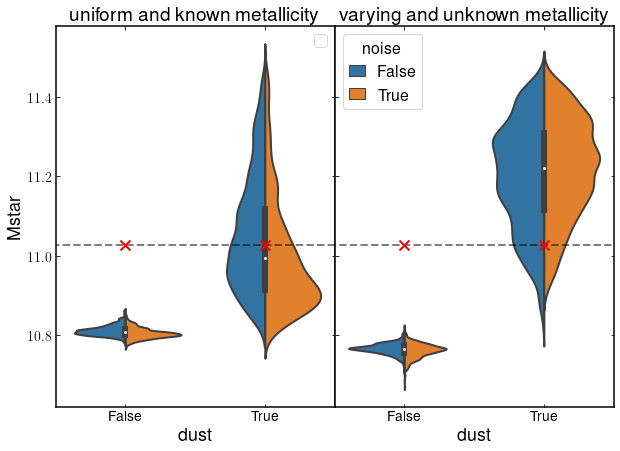

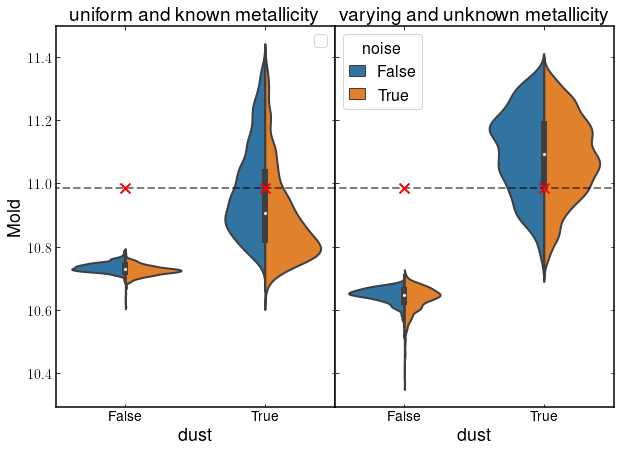

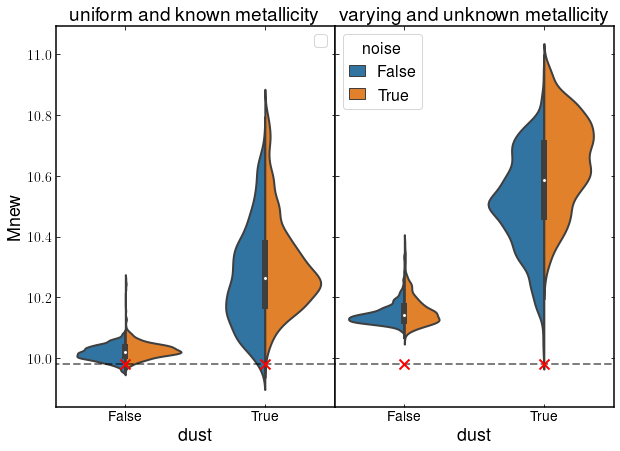

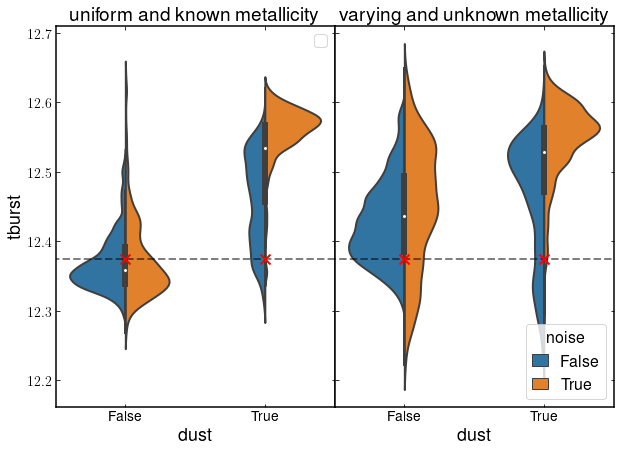

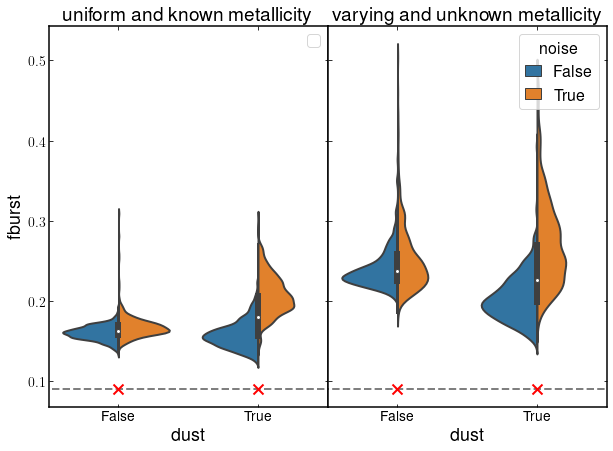

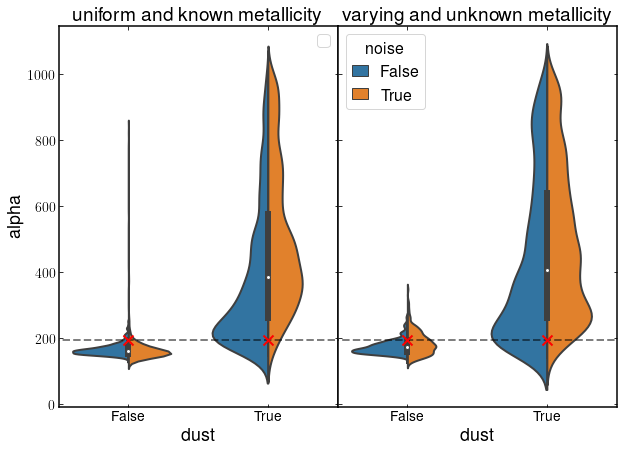

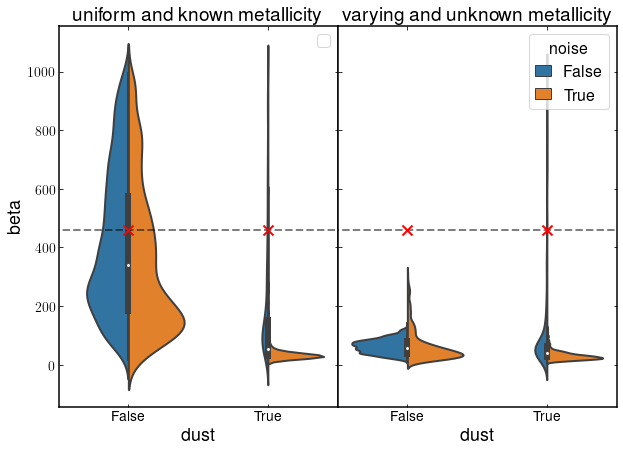

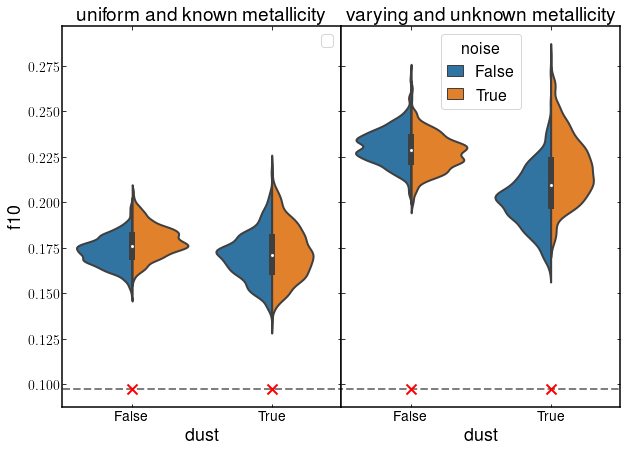

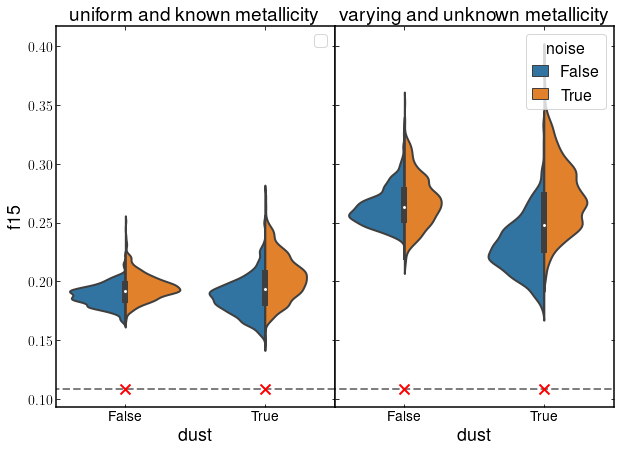

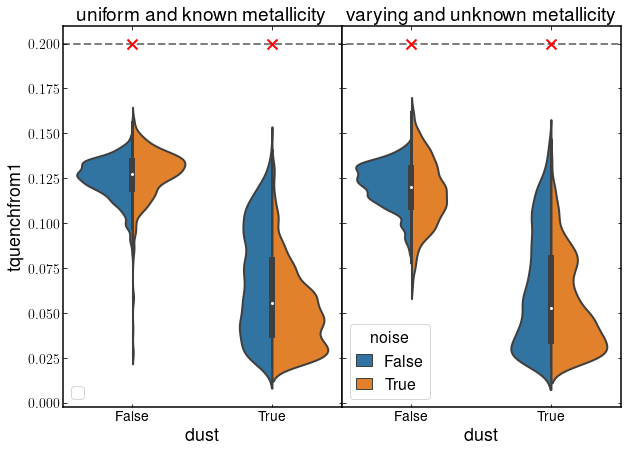

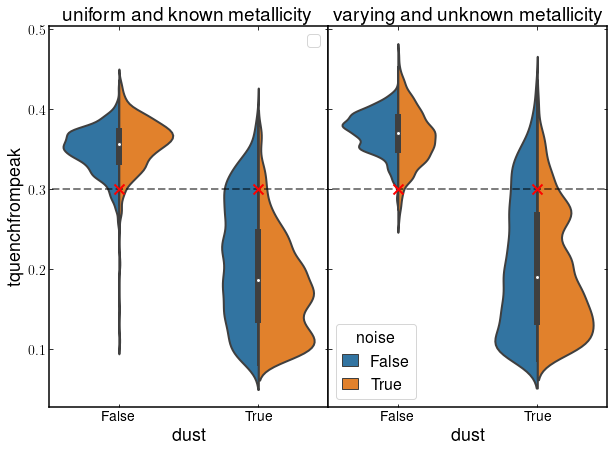

In [36]:
for param in ['Mstar', 'Mold', 'Mnew', 'tburst', 'fburst', 'alpha', 'beta',
              'f10', 'f15', 'tquenchfrom1', 'tquenchfrompeak']:
    violin_plot(param)